# Resource-constrained project scheduling
This example shows how to use PyJobshop to solve the resource-constrained project scheduling problem (RCPSP).

In the (RCPSP), machines are no longer disjunctive resources that can only process one task at a time. Instead, resources have capacaities and they can process multiple tasks simultaneously, and each task has a demand on the resource. Once a resource has finished a task, the demand is freed up again, that is, the resources are renewable. Tasks have a fixed duration and may consume multiple resources. Each task has a set of predecessors and successors, which are the tasks that must be completed before and after the current task, respectively. The goal of the RCPSP is to finish all tasks at minimum makespan.

## Instances

[PSPLIB](https://www.om-db.wi.tum.de/psplib/main.html) is a benchmark library for project scheduling problems. Below we define a class for parsing and storing an RCPSP instance from PSPLIB.

In [2]:
import re
from dataclasses import dataclass


@dataclass(frozen=True)
class RCPSP:
    """
    Problem data class for the RCPSP based on PSPLIB files.

    Code taken from:
    https://alns.readthedocs.io/en/latest/examples/resource_constrained_project_scheduling_problem.html
    """

    num_jobs: int  # jobs in RCPSP are tasks in PyJobshop
    num_resources: int
    duration: list[int]
    successors: list[list[int]]
    predecessors: list[list[int]]
    demands: list[list[int]]
    capacities: list[int]

    @classmethod
    def read_instance(cls, path: str) -> "RCPSP":
        """
        Reads an instance of the RCPSP from a file.
        Assumes the data is in the PSPLIB format.
        """
        with open(path) as fh:
            lines = fh.readlines()

        prec_idx = lines.index("PRECEDENCE RELATIONS:\n")
        req_idx = lines.index("REQUESTS/DURATIONS:\n")
        avail_idx = lines.index("RESOURCEAVAILABILITIES:\n")

        successors = []

        for line in lines[prec_idx + 2 : req_idx - 1]:
            _, _, _, _, *jobs, _ = re.split(r"\s+", line)
            successors.append([int(x) - 1 for x in jobs])

        predecessors: list[list[int]] = [[] for _ in range(len(successors))]

        for job in range(len(successors)):
            for succ in successors[job]:
                predecessors[succ].append(job)

        demands = []
        durations = []

        for line in lines[req_idx + 3 : avail_idx - 1]:
            _, _, _, duration, *consumption, _ = re.split(r"\s+", line)
            demands.append(list(map(int, consumption)))
            durations.append(int(duration))

        _, *avail, _ = re.split(r"\s+", lines[avail_idx + 2])
        capacities = list(map(int, avail))

        return RCPSP(
            len(durations),
            len(capacities),
            durations,
            successors,
            predecessors,
            demands,
            capacities,
        )

## Solving

Let's now create a Model class and define all problem data.

In [17]:
from pyjobshop import Model

instance = RCPSP.read_instance("../j9041_6.sm")
model = Model()

# It's not necessary to define jobs, but it will add coloring to the plot.
jobs = [model.add_job() for _ in range(instance.num_jobs)]
tasks = [model.add_task(job=jobs[idx]) for idx in range(instance.num_jobs)]
resources = [model.add_machine(capacity) for capacity in instance.capacities]

Next we define the processing modes of each task. A processing mode is one option for how to process a task: this includes the resources required for the task, the processing duration of the mode, and the demands for each resource. Unlike classical machine scheduling problems, we can require multiple resources at the same time.

In [18]:
for idx in range(instance.num_jobs):
    task = tasks[idx]
    duration = instance.duration[idx]
    demands = instance.demands[idx]
    model.add_mode(task, resources, duration, demands)

And finally we add the precedence constraints.

In [19]:
for idx in range(instance.num_jobs):
    task = tasks[idx]

    for pred in instance.predecessors[idx]:
        model.add_end_before_start(tasks[pred], task)

    for succ in instance.successors[idx]:
        model.add_end_before_start(task, tasks[succ])

In [20]:
result = model.solve(time_limit=5, display=False)
result.objective

140.0

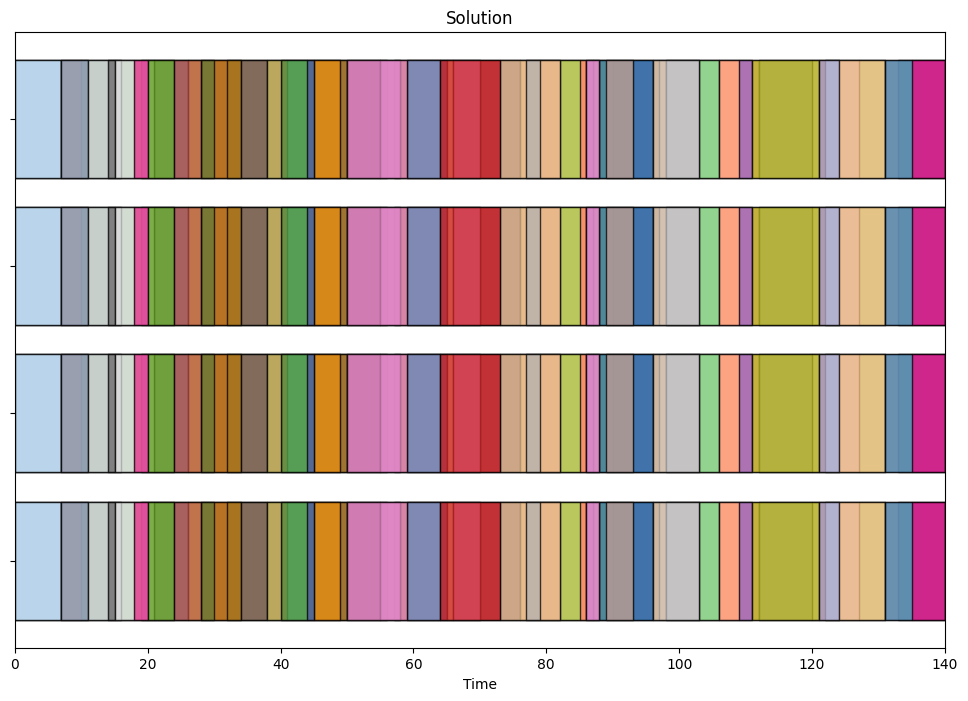

In [23]:
from pyjobshop import plot

plot(model.data(), result.best)  # TODO fix plotting.